# Zero-d networks

In figure 27 of arXiv:2010.15114, we show that when networks are highly regularized, they can be made zero-dimensional, i.e. all integrator modes are suppressed.  This notebook contains code to reproduce that figure.

In [1]:
import jax.numpy as jnp
import os
import numpy as np
import json

from jax.experimental import optimizers
from src import data, model_utils, optim_utils, measurements
from renn.rnn import network
from renn import utils, eigsorted

from data_processing import analysis_utils as au

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

import jetpack

build configs


In [2]:
cd ..

/usr/local/google/home/ramasesh/Projects/rnn_dynamics


## Load models and compute spectra

In [3]:
network_folders = {'GRU': 'reproduce_results/appendix/zero_d_networks/GRU/',
                  'LSTM': 'reproduce_results/appendix/zero_d_networks/LSTM/',
                  'UGRNN': 'reproduce_results/appendix/zero_d_networks/UGRNN/'}

eigenvalues = {}

for arch, data_folder in network_folders.items():
    
    # load config
    with open(os.path.join(data_folder, 'config.json')) as f:
        config = json.load(f)
        
    # load data
    vocab_size, train_dset, test_dset = data.get_dataset(config['data'])
    
    cell = model_utils.get_cell(config['model']['cell_type'],
                            num_units=config['model']['num_units'])
    
    init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
    
    network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
    emb_params, rnn_params, readout_params = network_params
    
    test_batch = next(iter(tfds.as_numpy(test_dset)))
    
    visited_states = au.rnn_states(cell, test_batch, rnn_params, emb_params, emb_apply)
    final_states = au.rnn_end_states(cell, test_batch, rnn_params, emb_params, emb_apply)
    
    fixed_points_, loss_hist, fp_losses = au.fixed_points(cell,
                                                    rnn_params,
                                                    visited_states,
                                                    tolerance=5e-6,
                                                    embedding_size=config['model']['emb_size'],
                                                    noise_scale=0.4,
                                                    decimation_factor=4
                                                    )

    # linearize around fixed-point 0
    linearization_point = fixed_points_[0]
    
    J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             linearization_point)

    _, E, _ = eigsorted(J_hh)
    eigenvalues[arch] = E

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.
(9138, 128)
(8821, 128)
(9070, 128)


## Make Figure

In [4]:
def plot_evals(evals, ax_obj):
    ax_obj.scatter(np.real(evals), np.imag(evals), c='k', marker='.')
    
def plot_unit_circle(ax_obj):
    t = np.linspace(0,np.pi*2,100)
    ax_obj.plot(np.cos(t),np.sin(t),linewidth=1)

def set_figure_settings(arch, arch_ind, ax_obj):
    ax_obj.set_aspect('equal')
    ax_obj.set_xlim(-1,1)
    ax_obj.set_ylim(-1,1)
    ax_obj.set_title(f'{arch}', fontsize=16)
    ax_obj.grid()
    ax_obj.set_xlabel('Real[$\lambda$]', fontsize=16)
 
    ax_obj.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax_obj.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax_obj.set_xticklabels([-1, -0.5, 0, 0.5, 1], fontsize=16)

    if arch_ind == 0:
        ax_obj.set_ylabel('Imag[$\lambda$]', fontsize=16)
        ax_obj.set_yticklabels([-1, -0.5, 0, 0.5, 1], fontsize=16)   
    

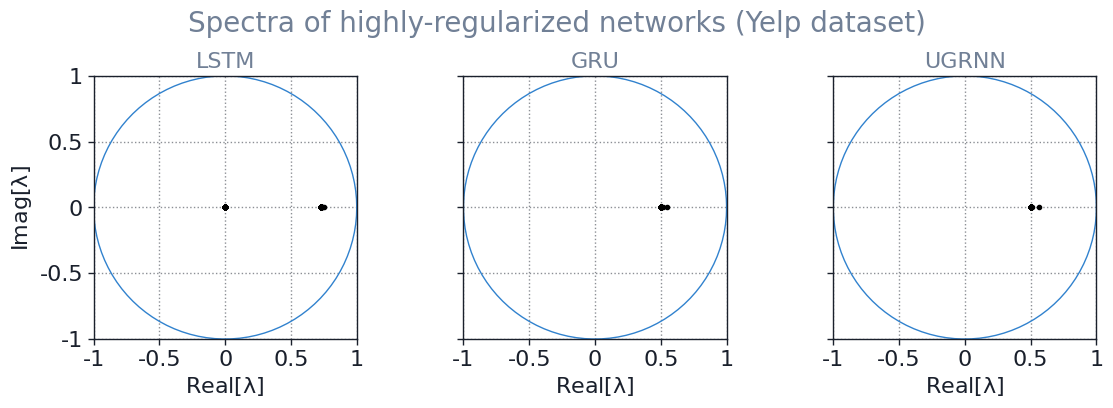

In [5]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3, sharey=True)    
architectures = ['LSTM', 'GRU', 'UGRNN']
for arch_ind, arch in enumerate(architectures):
    plot_evals(eigenvalues[arch], ax[arch_ind])
    plot_unit_circle(ax[arch_ind])
    set_figure_settings(arch, arch_ind, ax[arch_ind])
fig.suptitle('Spectra of highly-regularized networks (Yelp dataset)', fontsize=20);